In [1]:
import numpy as np
import cv2 as cv
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize



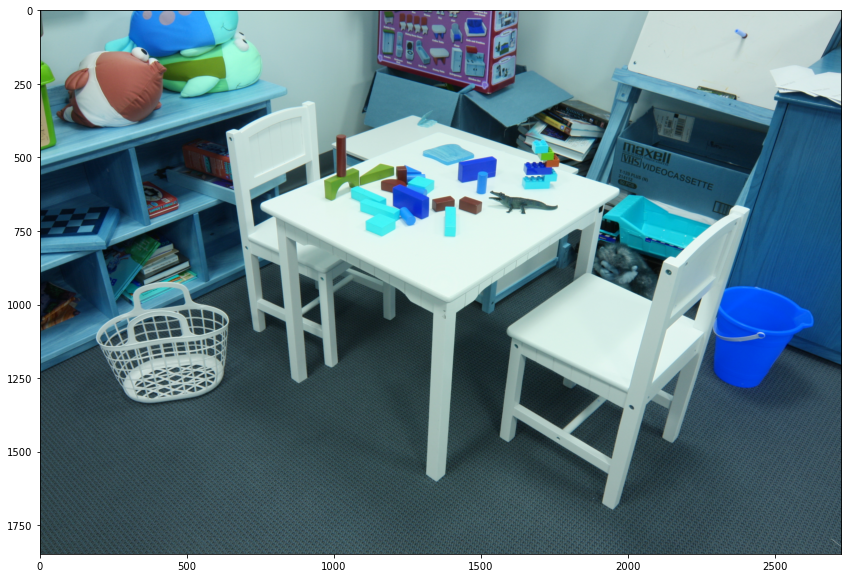

In [2]:
fig, ax = plt.subplots(figsize=(20, 10))

imgL = cv.imread('data/Middlebury/Playtable-perfect/im0.png')
imgR = cv.imread('data/Middlebury/Playtable-perfect/im1.png')

plt.imshow(imgL)
plt.show()

## First test, using simple SGBM

computing disparity...


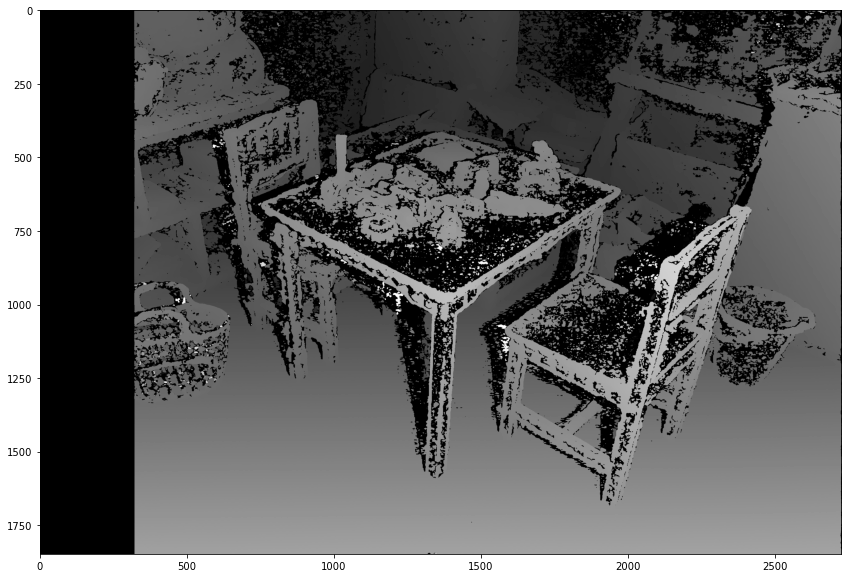

In [3]:
window_size = 5
min_disp = 0
num_disp = 320
stereo = cv.StereoSGBM_create(minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = 8,
    P1 = 8*3*window_size**2,
    P2 = 32*3*window_size**2,
    disp12MaxDiff = 1,
    uniquenessRatio = 15,
    speckleWindowSize = 0,
    speckleRange = 2,
    mode=cv.STEREO_SGBM_MODE_SGBM
)

print('computing disparity...')
disp = stereo.compute(imgL, imgR)
norm_disp = (disp-min_disp)/num_disp

fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(norm_disp,'gray')
plt.show()

## Second method using 'mode 3way' + disparity map post-filtering

In [4]:
window_size = 3
 
left_matcher = cv.StereoSGBM_create(
    minDisparity=0,
    numDisparities=288,             
    blockSize=5,
    P1=8 * 3 * window_size ** 2,    
    P2=32 * 3 * window_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=0,
    speckleRange=2,
    preFilterCap=2,
    mode=cv.STEREO_SGBM_MODE_SGBM_3WAY
)

right_matcher = cv.ximgproc.createRightMatcher(left_matcher)

In [5]:
print('computing disparity...')
displ = left_matcher.compute(imgL, imgR)
dispr = right_matcher.compute(imgR, imgL)
displ = np.int16(displ)
dispr = np.int16(dispr)

computing disparity...


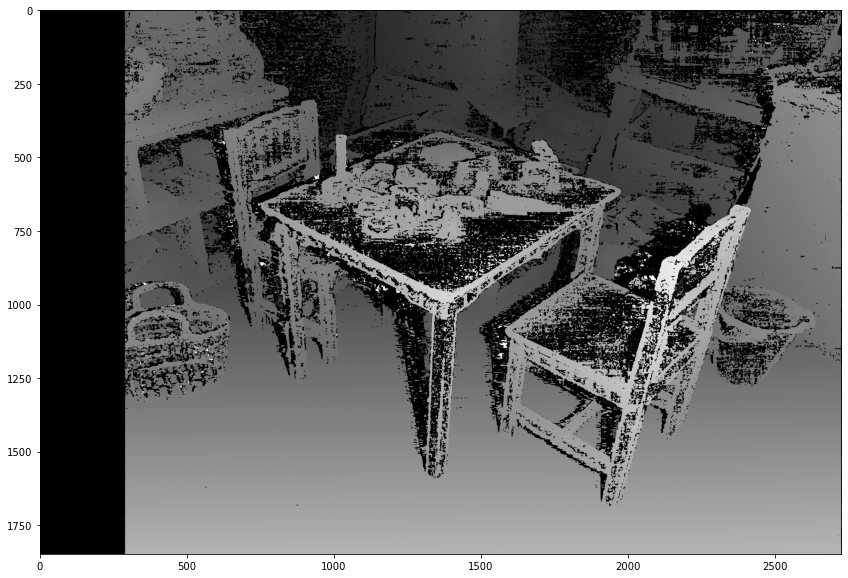

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(displ,'gray')
plt.show()

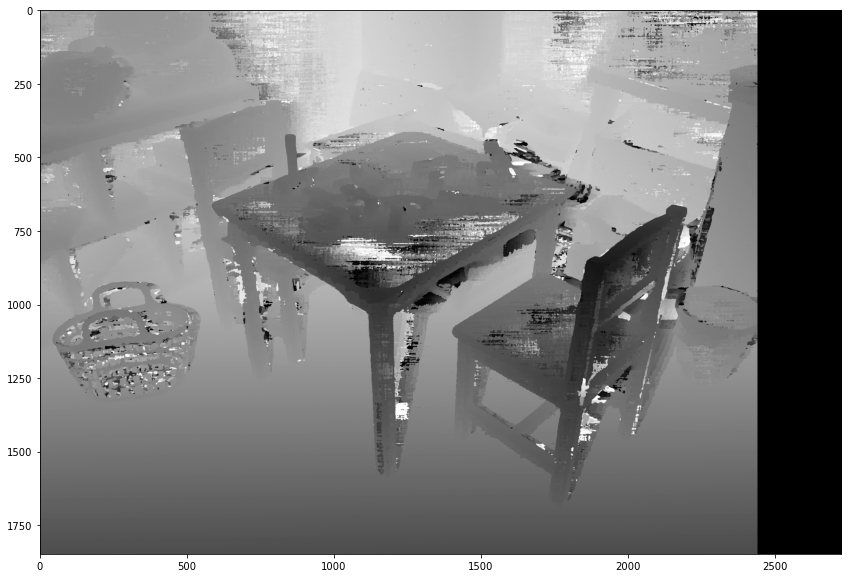

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(dispr,'gray')
plt.show()

In [8]:
##FILTER Parameters
# lmbda = 80000
# sigma = 1.2

lmbda = 160000
sigma = 1.8


wls_filter = cv.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(lmbda)
wls_filter.setSigmaColor(sigma)

In [9]:
filteredImg = wls_filter.filter(displ, imgL, None, dispr)

In [10]:
filteredImg.min(), filteredImg.max()

(-16, 4217)

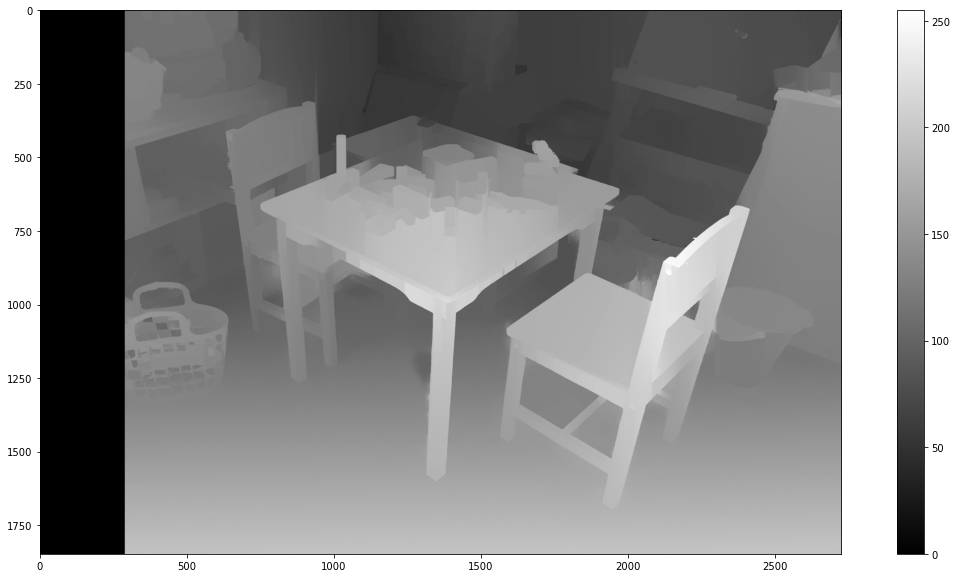

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))

filteredImg = cv.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv.NORM_MINMAX);
filteredImg = np.uint8(filteredImg)

gray = cm.gray
m = cm.ScalarMappable(cmap=gray)
m.set_array([filteredImg.min(),filteredImg.max()])
plt.colorbar(m, ax=ax)

plt.imshow(filteredImg, 'gray')
plt.show()

In [12]:
cv.imwrite("data/disparidade.pgm",filteredImg)

True

### Make depth map

In [13]:
filteredImg = wls_filter.filter(displ, imgL, None, dispr)

In [14]:
### dividir por 16 pela saída do WLS
filteredImg = filteredImg/16
filteredImg

array([[ -1.    ,  -1.    ,  -1.    , ...,  73.0625,  73.0625,  73.125 ],
       [ -1.    ,  -1.    ,  -1.    , ...,  73.0625,  73.0625,  73.125 ],
       [ -1.    ,  -1.    ,  -1.    , ...,  73.0625,  73.0625,  73.125 ],
       ...,
       [ -1.    ,  -1.    ,  -1.    , ..., 202.3125, 202.3125, 202.    ],
       [ -1.    ,  -1.    ,  -1.    , ..., 202.3125, 202.3125, 202.    ],
       [ -1.    ,  -1.    ,  -1.    , ..., 202.3125, 202.3125, 202.    ]])

In [15]:
# def relu(m):
#     m[m < 0] = 0

# #relu(filteredImg)
# np.abs(filteredImg)
# #filteredImg

In [16]:
# filteredImg = filteredImg + 1

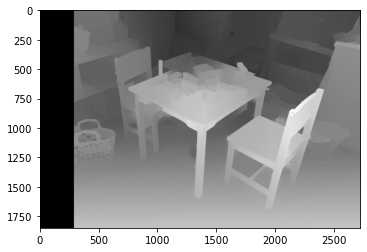

In [17]:
plt.imshow(filteredImg, 'gray')
plt.show()

In [18]:
# Z = baseline * f / (d + doffs)
filteredImg_2 = filteredImg + 100.279
filteredImg_2 = 193.006 * 2329.558 / filteredImg_2
# filteredImg_2 = filteredImg_2/1000

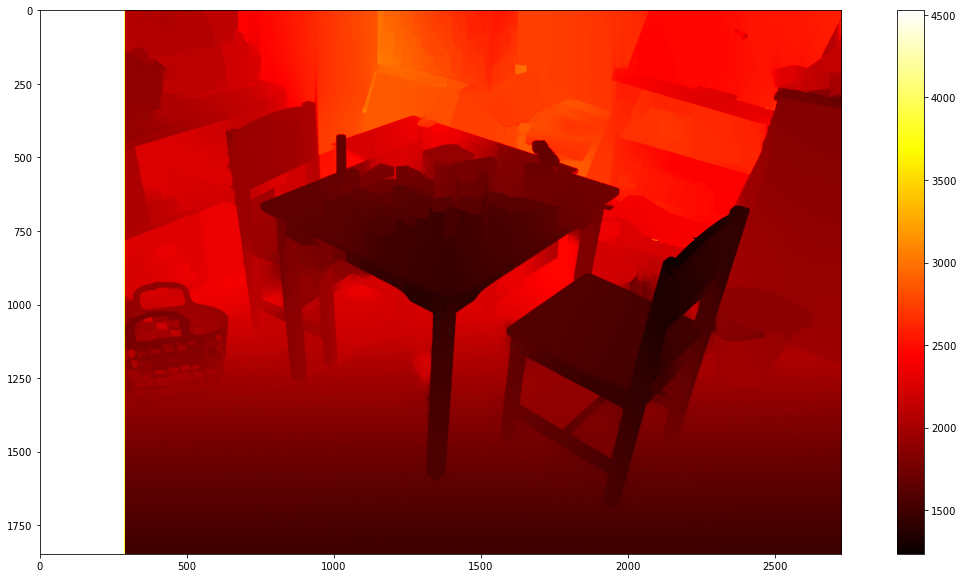

In [21]:
fig, ax = plt.subplots(figsize=(20, 10))
#filteredImg_2 = cv.normalize(src=filteredImg_2, dst=filteredImg_2, beta=0, alpha=254, norm_type=cv.NORM_MINMAX);
#filteredImg_2 = np.uint8(filteredImg_2)

hot = cm.hot
m = cm.ScalarMappable(cmap=hot)
m.set_array([filteredImg_2.min(),filteredImg_2.max()])
plt.colorbar(m, ax=ax)

plt.imshow(filteredImg_2, 'hot')
plt.show()